# Test 1 : Parameter Tuning

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path
import sys
import seaborn as sns

# For ipynb environemnt

try:
    SCRIPT_DIR = Path(__file__).resolve().parent
except NameError:
    # We are in a notebook/interactive session
    SCRIPT_DIR = Path(os.getcwd()).resolve()

# Adjust this based on where your 'logs' folder is relative to the notebook
# If 'logs' is in the same folder as your notebook, use SCRIPT_DIR
# If 'logs' is one level up, use SCRIPT_DIR.parent
PROJECT_ROOT = SCRIPT_DIR.parent

LOG_FILE = PROJECT_ROOT / "logs" / "param_sweep_log.csv"
PLOT_DIR = PROJECT_ROOT / "logs" / "plots"

print(f"Looking for log file at: {LOG_FILE}")

def load_data(LOG_FILE):
    if not os.path.exists(LOG_FILE):
        print(f"Error: Log file not found at {LOG_FILE}")
        sys.exit(1)

    try:
        df = pd.read_csv(LOG_FILE)
        # Clean column names (remove spaces)
        df.columns = df.columns.str.strip()
        df.columns = df.columns.str.lower()
        return df
    except Exception as e:
        print(f"Error reading CSV: {e}")
        sys.exit(1)


Looking for log file at: /Users/nautilus/gridfw/logs/param_sweep_log.csv


In [20]:
df = load_data(LOG_FILE=LOG_FILE)
# 1. Normalize the Metric (Relative Error)
df['relative_error'] = (1 - df['ratio']) * 100

In [21]:
df

,timestamp,dataset,p,experiment,k,steps,samples,alpha,greedy_obj,fw_obj,ratio,greedy_time_s,fw_time_s,speedup_x,status,relative_error
0,2026-01-27 21:45:09,Residential,103,tune_a0.5_nmc20,10,200,20,0.500,94.3341,82.2639,0.8720,0.0107,0.0359,0.2970,DONE,12.80
1,2026-01-27 21:45:23,Residential,103,tune_a0.5_nmc20,10,200,20,0.500,94.3341,84.0050,0.8905,0.0107,0.0355,0.3002,DONE,10.95
2,2026-01-27 21:46:03,Synthetic_high_corr,1000,tune_a0.001_nmc20,100,2000,20,0.001,987.8376,987.4795,0.9996,6.1906,11.3240,0.5467,DONE,0.04
3,2026-01-27 21:46:09,Mnist,639,tune_a0.001_nmc20,63,1260,20,0.001,367.5541,300.9604,0.8188,1.3465,2.8281,0.4761,DONE,18.12
4,2026-01-27 21:46:11,Madelon,500,tune_a0.001_nmc20,50,1000,20,0.001,73.8241,58.8262,0.7968,0.7126,1.2766,0.5582,DONE,20.32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,2026-01-27 22:10:08,Synthetic_toeplitz,500,tune_a0.5_nmc500,50,1000,500,0.500,341.9858,325.5518,0.9519,0.6627,5.6266,0.1178,DONE,4.81
238,2026-01-27 22:10:09,Residential,103,tune_a0.5_nmc500,10,200,500,0.500,94.3341,89.4849,0.9486,0.0110,0.4860,0.0226,DONE,5.14
239,2026-01-27 22:10:19,Secom,478,tune_a0.5_nmc500,47,940,500,0.500,264.4359,234.8679,0.8882,0.5608,5.1071,0.1098,DONE,11.18
240,2026-01-27 22:10:22,Arrhythmia,262,tune_a0.5_nmc500,26,520,500,0.500,141.5791,138.0806,0.9753,0.1190,1.6680,0.0713,DONE,2.47


/var/folders/7c/q9_nslk55p94jf29j5gtcsxc0000gn/T/ipykernel_18253/309551658.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


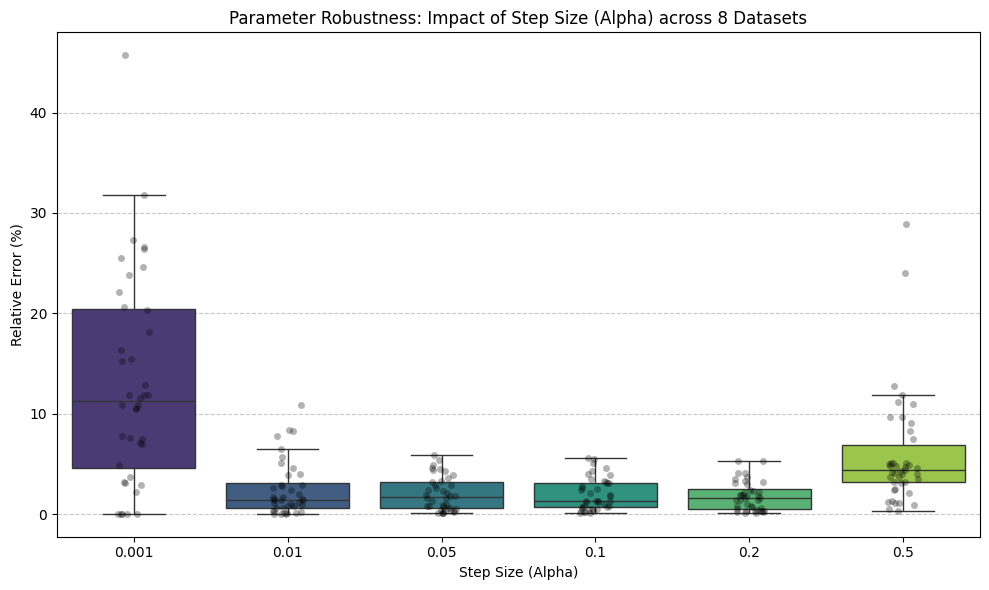

In [6]:
def plot_box_all_datasets_error():
    plt.figure(figsize=(10, 6))

    # 2. Create the Box Plot
    # This groups all 8 datasets together for each Alpha
    sns.boxplot(
        x="alpha", 
        y="relative_error", 
        data=df, 
        palette="viridis", 
        showfliers=False # Hide extreme outliers to keep the scale readable
    )

    # 3. Overlay the actual data points (jitter)
    # This shows the reader that you have 8 real data points per box
    sns.stripplot(x="alpha", y="relative_error", data=df, color='black', alpha=0.3, jitter=True)

    plt.title("Parameter Robustness: Impact of Step Size (Alpha) across 8 Datasets")
    plt.ylabel("Relative Error (%)")
    plt.xlabel("Step Size (Alpha)")
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # 5. Save and Show
    save_path = PROJECT_ROOT / "logs" / "plots" / f"box_all_data_errors.pdf"
    save_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(save_path, dpi=300)
    plt.show()

    
plot_box_all_datasets_error()

In [ ]:
def extract_table(df, dataset_names=None, tolerance=-3.0 ):
    df = df.copy()
    results = []
    
    # Iterate through each unique alpha
    for (ds, m), group in df.groupby(['alpha']):
        
        # A. Max Speedup
        max_speedup = group['relative_error'].max()
        
        # B. Critical k/p (First ratio where error stays above tolerance)
        # Sort by k_ratio to check the path
        # sorted_group = group.sort_values('k_ratio')
        # critical_kp = np.nan
        # for i in range(len(sorted_group)):
        #     # Check if current and all subsequent errors are above threshold
        #     if (sorted_group.iloc[i:]['rel_err'] >= tolerance).all():
        #         critical_kp = sorted_group.iloc[i]['k_ratio']
        #         break
        
        # C. Max Error (Worst case) and its location
        max_err_idx = group['rel_err'].idxmax() # Most negative
        max_err_val = group.loc[max_err_idx, 'rel_err']
        max_err_loc = group.loc[max_err_idx, 'k_ratio']
        
        # D. Min Error (Best case) and its location
        min_err_idx = group['rel_err'].idxmin() # Most positive/closest to zero
        min_err_val = group.loc[min_err_idx, 'rel_err']
        min_err_loc = group.loc[min_err_idx, 'k_ratio']
        
        results.append({
            "Dataset": ds,
            "m": m,
            "Max Speedup": f"{max_speedup:.2f}x",
            "Critical k/p": f"{critical_kp:.3f}" if not np.isnan(critical_kp) else "> 0.5",
            "Max Error %": f"{max_err_val:.2f}% (at {max_err_loc:.2f})",
            "Min Error %": f"{min_err_val:.2f}% (at {min_err_loc:.2f})"
        })

    return pd.DataFrame(results).sort_values(['Dataset', 'm'])

In [14]:
def plot_heat_all_alpha_error():
    # Create a Grid of Heatmaps (4 rows x 2 columns)
    g = sns.FacetGrid(df, col="Dataset", col_wrap=4, height=3, aspect=1.2, sharey=False)
    def draw_heatmap(data, **kwargs):
        # USE pivot_table INSTEAD OF pivot
        # 'aggfunc="mean"' fixes the duplicate error by averaging duplicates
        pivot = data.pivot_table(
            index="Alpha", 
            columns="Samples", 
            values="Relative Error (%)", 
            aggfunc="mean"
        )
        
        # Draw heatmap
        sns.heatmap(pivot, annot=False, cmap="Reds", cbar=False)
    # Map the heatmap function to the grid
    g.map_dataframe(draw_heatmap)

    # Add labels
    g.set_axis_labels("Samples (m)", "Alpha")
    g.set_titles(col_template="{col_name}")

    # Invert Y axis for all plots so small Alpha is at bottom
    for ax in g.axes.flat:
        ax.invert_yaxis()

    plt.subplots_adjust(top=0.9)
    g.figure.suptitle('Sensitivity Analysis across All Datasets (Relative Error %)')
    plt.show()

In [ ]:


def plot_box_one_datasets_error(dataset_name):
    # 1. Filter data ONCE so both plots use the same subset
    subset = df[df['Dataset'] == dataset_name].copy()
    
    if subset.empty:
        print(f"Skipping {dataset_name} (No data)")
        return

    # Create figure with a good aspect ratio for grid placement
    plt.figure(figsize=(10, 6))

    # 2. Create the Box Plot (Thicker lines for PDF visibility)
    sns.boxplot(
        x="Alpha", 
        y="Relative Error (%)", 
        data=subset,  # <--- FIXED: Use subset, not df
        palette="viridis", 
        showfliers=False,
        linewidth=1.5 
    )

    # 3. Overlay the actual data points (jitter)
    sns.stripplot(
        x="Alpha", 
        y="Relative Error (%)", 
        data=subset,
        color='black', 
        alpha=0.3, 
        jitter=True
    )

    plt.ylabel("Relative Error (%)", fontsize=14, fontweight='bold')
    plt.xlabel("Step Size (Alpha)", fontsize=14, fontweight='bold')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()

    # 5. Save and Close
    save_path = PROJECT_ROOT / "logs" / "plots"/ "box_alpha_errors" / f"box_{dataset_name}_data_errors.pdf"
    
    save_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.close()
    print(f"Saved: {save_path.name}")

# --- Run the Loop ---
for dataset_name in df["Dataset"].unique():
    plot_box_one_datasets_error(dataset_name)

/var/folders/7c/q9_nslk55p94jf29j5gtcsxc0000gn/T/ipykernel_32340/4006469497.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/7c/q9_nslk55p94jf29j5gtcsxc0000gn/T/ipykernel_32340/4006469497.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/7c/q9_nslk55p94jf29j5gtcsxc0000gn/T/ipykernel_32340/4006469497.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


Saved: box_Residential_data_errors.pdf
Saved: box_Synthetic_high_corr_data_errors.pdf
Saved: box_Mnist_data_errors.pdf


/var/folders/7c/q9_nslk55p94jf29j5gtcsxc0000gn/T/ipykernel_32340/4006469497.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/7c/q9_nslk55p94jf29j5gtcsxc0000gn/T/ipykernel_32340/4006469497.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/7c/q9_nslk55p94jf29j5gtcsxc0000gn/T/ipykernel_32340/4006469497.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


Saved: box_Madelon_data_errors.pdf
Saved: box_Synthetic_toeplitz_data_errors.pdf
Saved: box_Secom_data_errors.pdf
Saved: box_Arrhythmia_data_errors.pdf
Saved: box_Myocardial_data_errors.pdf


/var/folders/7c/q9_nslk55p94jf29j5gtcsxc0000gn/T/ipykernel_32340/4006469497.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
/var/folders/7c/q9_nslk55p94jf29j5gtcsxc0000gn/T/ipykernel_32340/4006469497.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


In [ ]:
def plot_one_dataset_heatmap_alpha_m_error(df, dataset_name):
    """
    Generates a side-by-side Heatmap (Error vs Time) for a specific dataset.
    """
    # Filter data for this specific dataset
    subset = df[df['dataset'] == dataset_name].copy()
    
    if subset.empty:
        print(f"⚠️ Warning: No data found for dataset '{dataset_name}'")
        return

    # Calculate Relative Error % (100 - Ratio*100)
    # subset['relative_error'] = (1 - subset['ratio']) * 100

    # Setup the figure (Side-by-Side)
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # --- PLOT A: ACCURACY (Relative Error) ---
    # Use pivot_table with aggfunc='mean' to handle duplicate runs safely
    piv_acc = subset.pivot_table(index="Alpha", columns="Samples", values="Relative Error (%)", aggfunc="mean")
    sns.heatmap(piv_acc, annot=True, fmt=".1f", cmap="Reds", ax=axes[0], cbar_kws={'label': 'Relative Error (%)'})
    axes[0].set_title(f"{dataset_name}: Optimization Error (Lower is Better)")
    axes[0].invert_yaxis() # Put small alpha at the bottom

    # --- PLOT B: EFFICIENCY (Runtime) ---
    piv_time = subset.pivot_table(index="Alpha", columns="Samples", values="FW_Time_s", aggfunc="mean")
    sns.heatmap(piv_time, annot=True, fmt=".2f", cmap="Blues", ax=axes[1], cbar_kws={'label': 'Runtime (s)'})
    axes[1].set_title(f"{dataset_name}: Runtime (Seconds)")
    axes[1].invert_yaxis()

    plt.tight_layout()
        # 5. Save and Show
    save_path = PROJECT_ROOT / "logs" / "plots"/ "heatmap_alpha_m_errors" / f"heat_{dataset_name}_data_errors.pdf"
    save_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(save_path, dpi=300)
    plt.show()

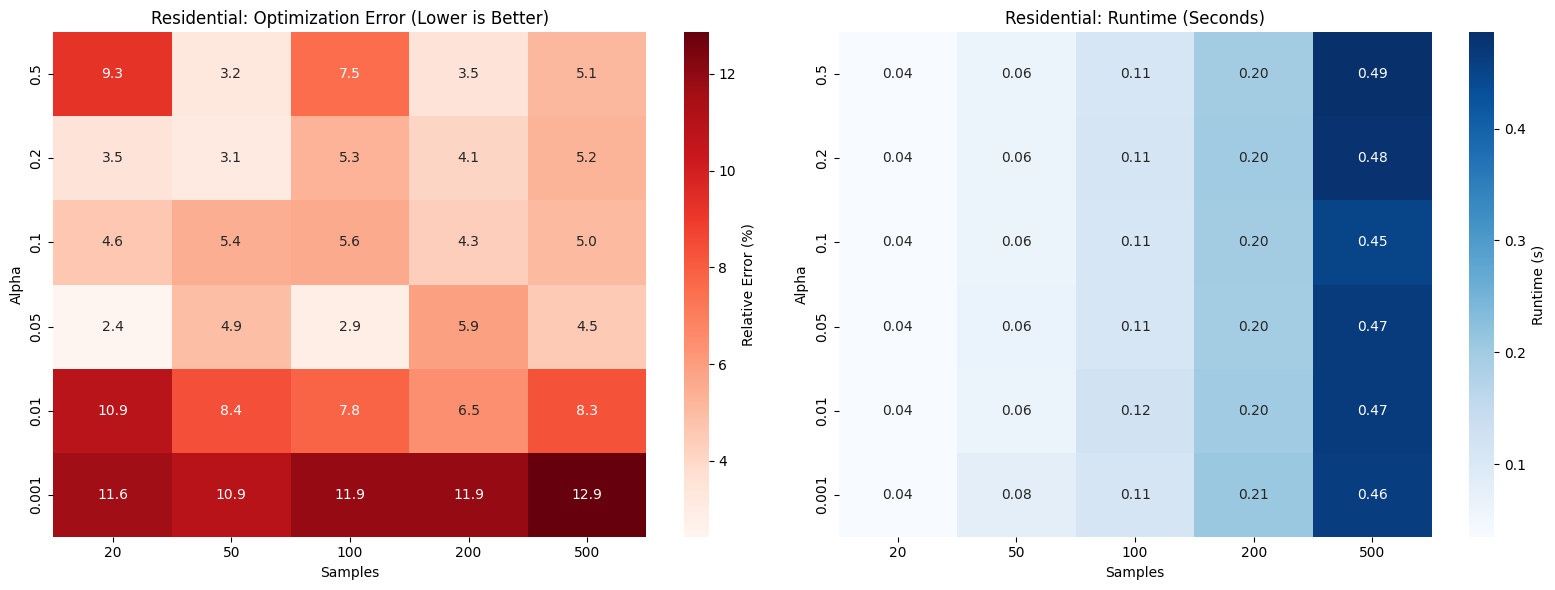

In [ ]:
plot_one_dataset_heatmap_alpha_m_error(df, "Residential")

/var/folders/7c/q9_nslk55p94jf29j5gtcsxc0000gn/T/ipykernel_18253/219265117.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


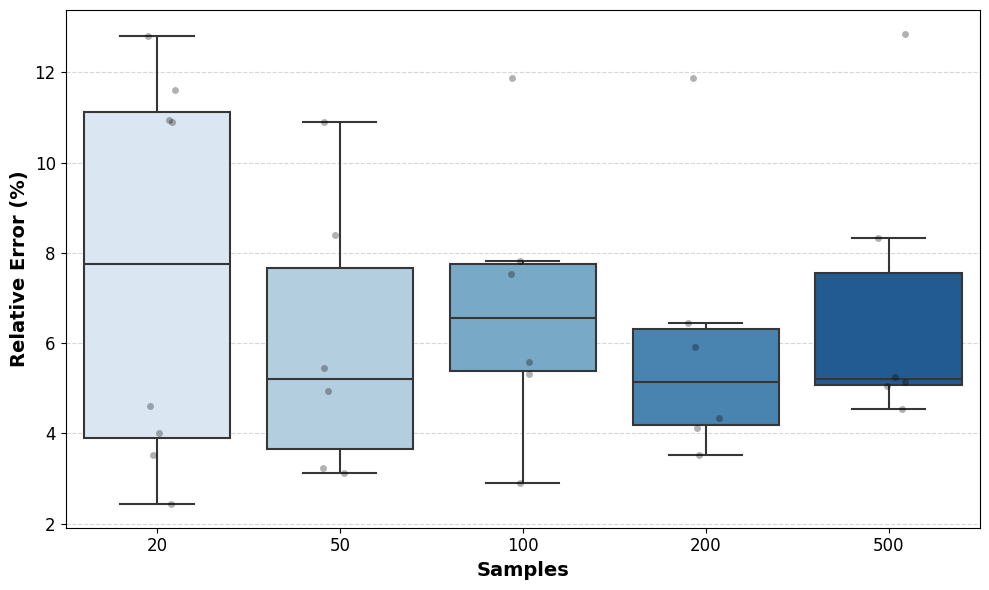

/var/folders/7c/q9_nslk55p94jf29j5gtcsxc0000gn/T/ipykernel_18253/219265117.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


Saved: box_Residential_sample_errors.pdf


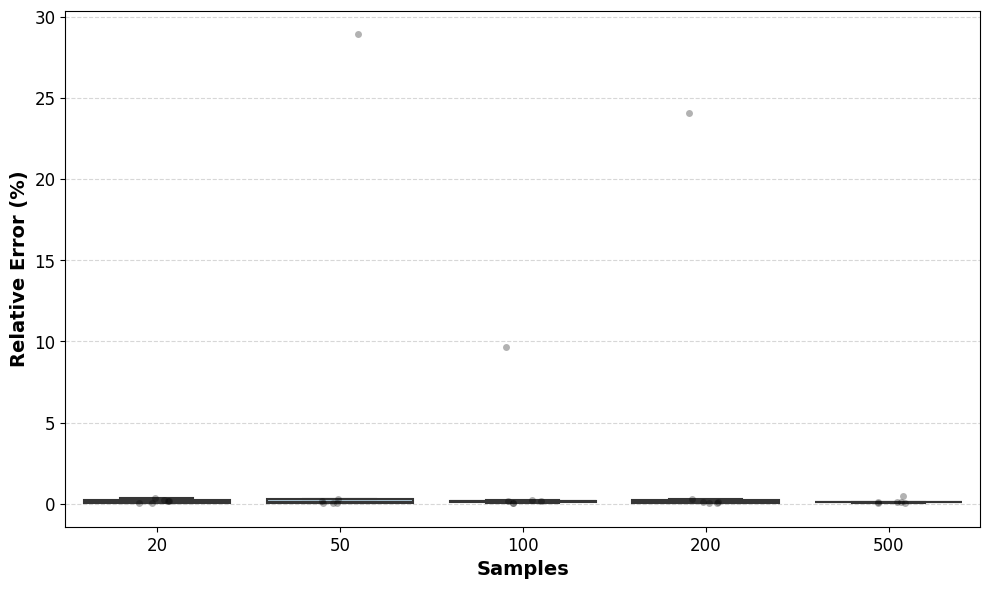

Saved: box_Synthetic_high_corr_sample_errors.pdf


/var/folders/7c/q9_nslk55p94jf29j5gtcsxc0000gn/T/ipykernel_18253/219265117.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


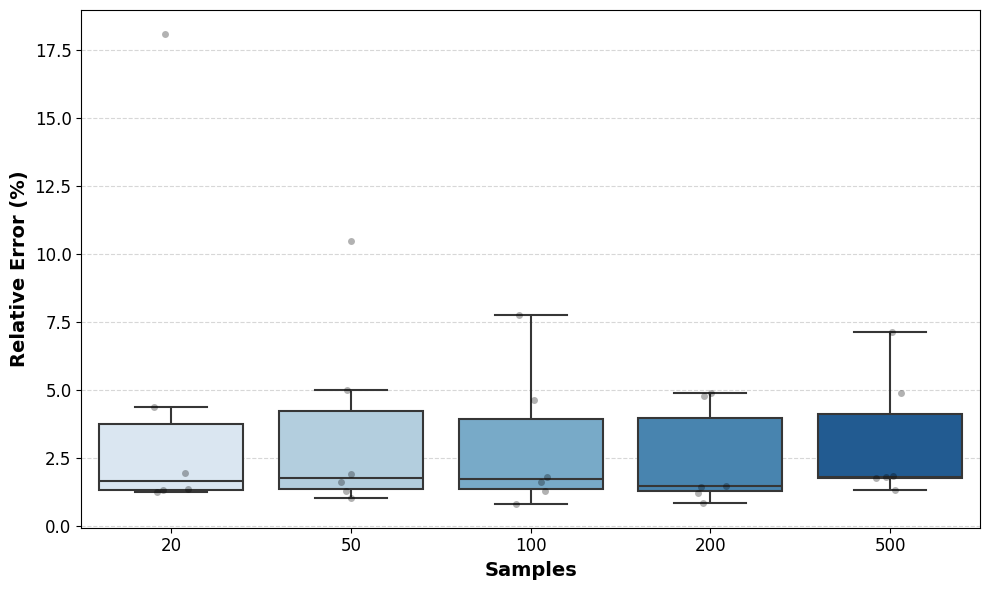

Saved: box_Mnist_sample_errors.pdf


/var/folders/7c/q9_nslk55p94jf29j5gtcsxc0000gn/T/ipykernel_18253/219265117.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


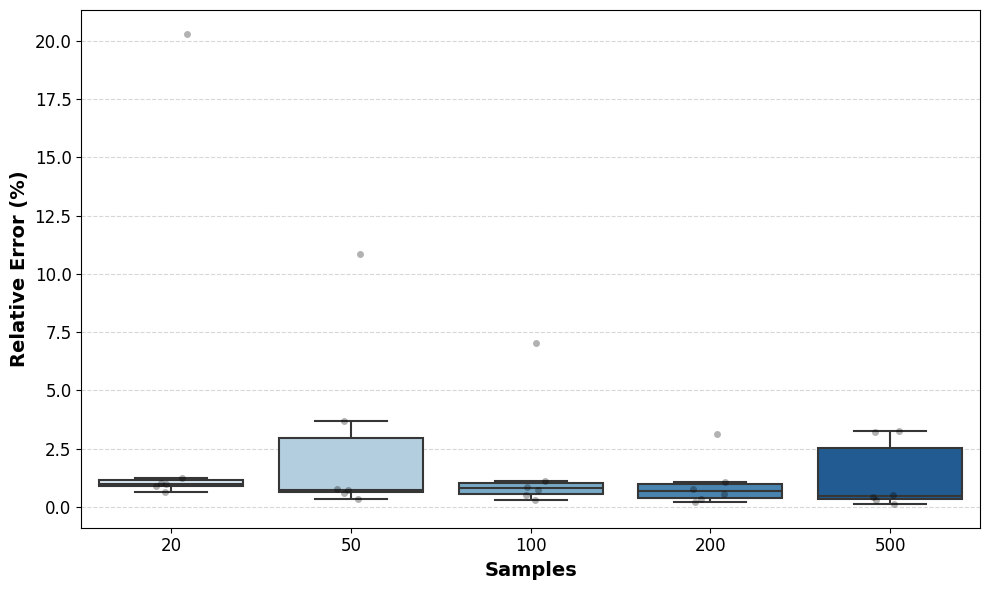

Saved: box_Madelon_sample_errors.pdf


/var/folders/7c/q9_nslk55p94jf29j5gtcsxc0000gn/T/ipykernel_18253/219265117.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


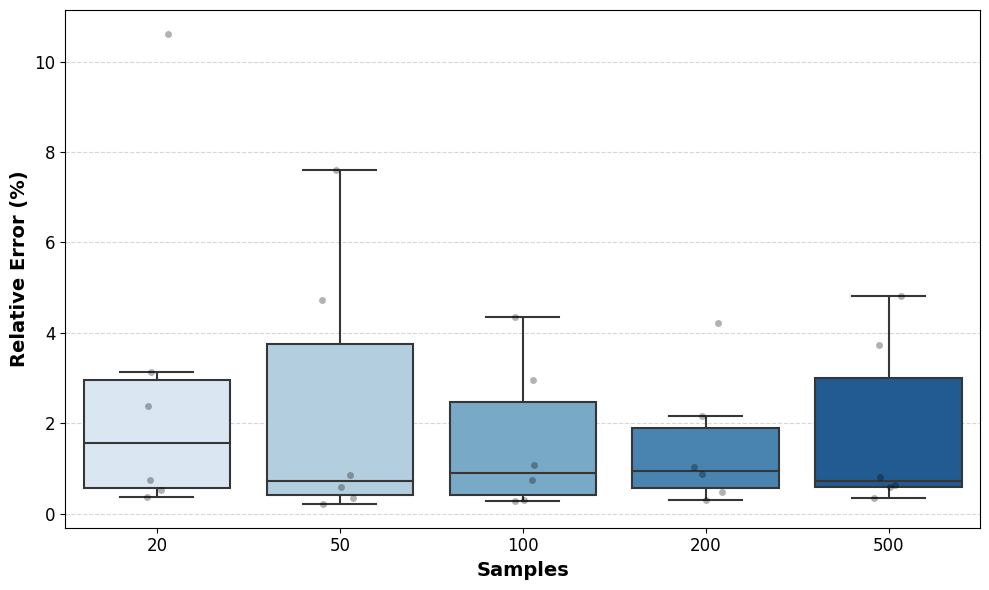

Saved: box_Synthetic_toeplitz_sample_errors.pdf


/var/folders/7c/q9_nslk55p94jf29j5gtcsxc0000gn/T/ipykernel_18253/219265117.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


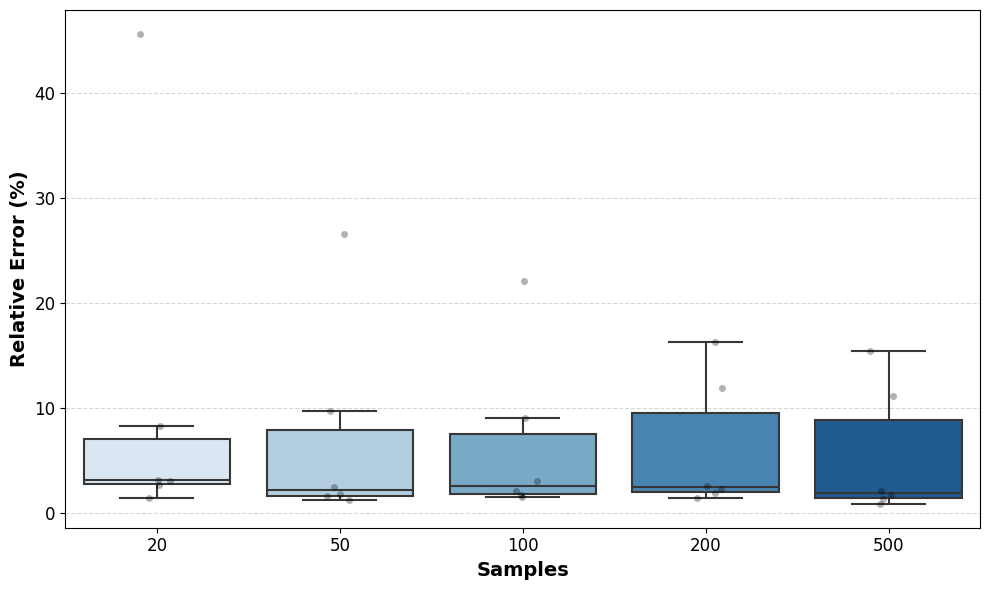

Saved: box_Secom_sample_errors.pdf


/var/folders/7c/q9_nslk55p94jf29j5gtcsxc0000gn/T/ipykernel_18253/219265117.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


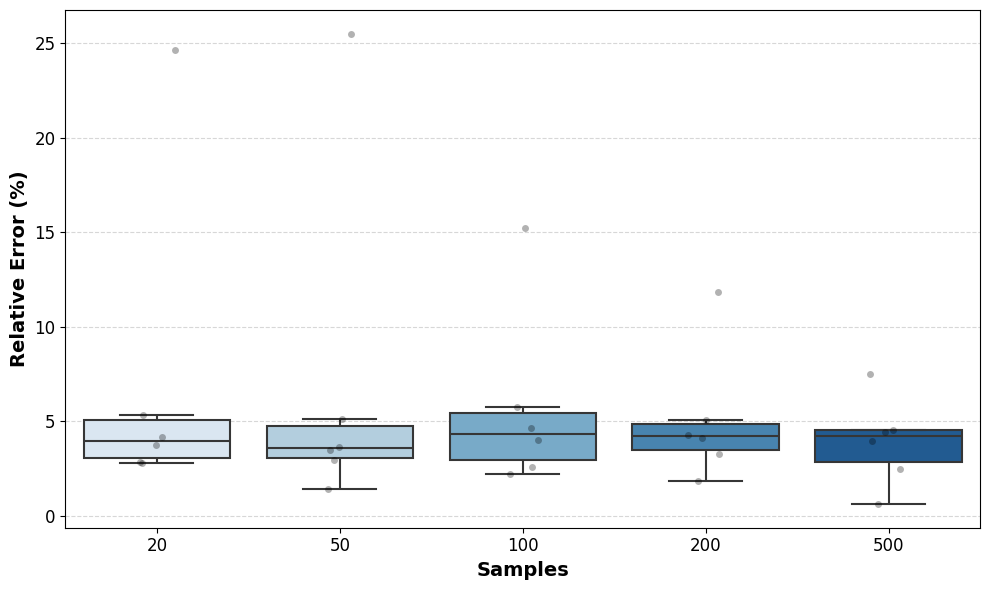

Saved: box_Arrhythmia_sample_errors.pdf


/var/folders/7c/q9_nslk55p94jf29j5gtcsxc0000gn/T/ipykernel_18253/219265117.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


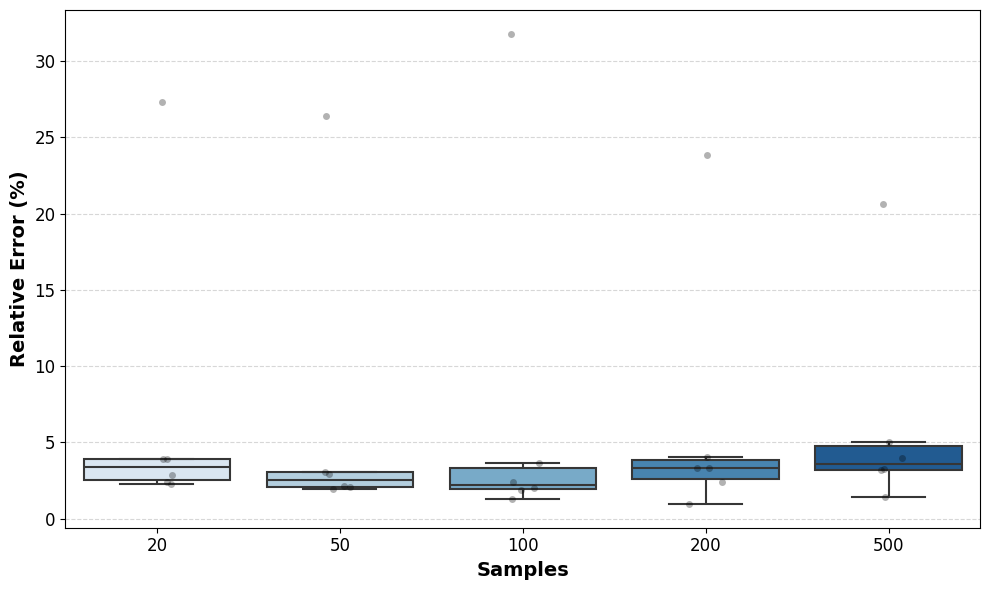

Saved: box_Myocardial_sample_errors.pdf


In [24]:

# df = load_data(LOG_FILE)
# df['Relative Error (%)'] = (1 - df['Ratio']) * 100

def plot_box_one_datasets_error_alpha(dataset_name):
    # 1. Filter data ONCE so both plots use the same subset
    subset = df[df['dataset'] == dataset_name].copy()
    
    if subset.empty:
        print(f"Skipping {dataset_name} (No data)")
        return

    # Create figure with a good aspect ratio for grid placement
    plt.figure(figsize=(10, 6))

    # 2. Create the Box Plot (Thicker lines for PDF visibility)
    sns.boxplot(
        x="samples", 
        y="relative_error", 
        data=subset,  
        palette="Blues", 
        showfliers=False,
        linewidth=1.5 
    )

    # 3. Overlay the actual data points (jitter)
    sns.stripplot(
        x="samples", 
        y="relative_error", 
        data=subset,
        color='black', 
        alpha=0.3, 
        jitter=True
    )

    plt.ylabel("Relative Error (%)", fontsize=14, fontweight='bold')
    plt.xlabel("Samples", fontsize=14, fontweight='bold')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()

    # 5. Save and Close
    save_path = PROJECT_ROOT / "logs" / "plots"/ "box_sample_errors" / f"box_{dataset_name}_sample_errors.pdf"
    
    save_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Saved: {save_path.name}")

# --- Run the Loop ---
for dataset_name in df["dataset"].unique():
    plot_box_one_datasets_error_alpha(dataset_name)

/var/folders/7c/q9_nslk55p94jf29j5gtcsxc0000gn/T/ipykernel_32340/2067711313.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


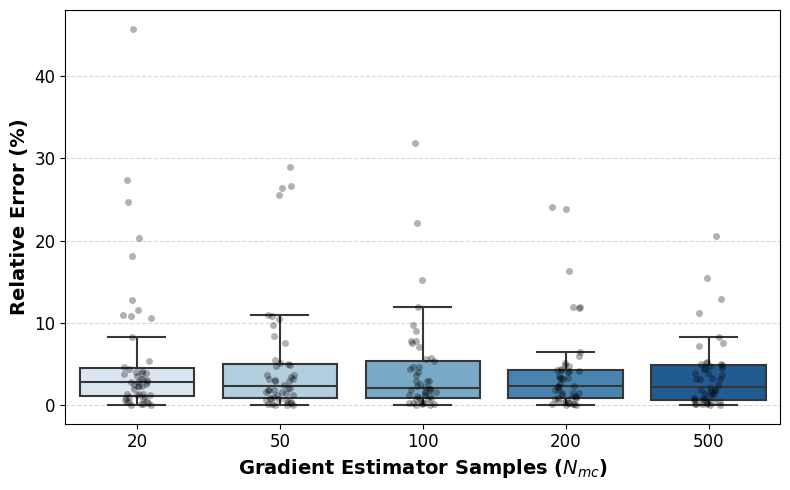

In [18]:

# Load Data (if not already loaded)
# df = pd.read_csv("logs/param_sweep_log.csv")
df = load_data(LOG_FILE)
df['Relative Error (%)'] = (1 - df['Ratio']) * 100

# Setup Figure (Standard Academic Size)
plt.figure(figsize=(8, 5))

# Box Plot: X = Samples, Y = Error
sns.boxplot(
    x="Samples", 
    y="Relative Error (%)", 
    data=df, 
    palette="Blues", # Use Blue to distinguish from Alpha (Green/Purple)
    showfliers=False,
    linewidth=1.5
)

# Jitter Points (shows the density of data)
sns.stripplot(x="Samples", y="Relative Error (%)", data=df, color='black', alpha=0.3, jitter=True)

# Thesis Styling
plt.xlabel(r"Gradient Estimator Samples ($N_{mc}$)", fontsize=14, fontweight='bold')
plt.ylabel("Relative Error (%)", fontsize=14, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()

# Save
# os.makedirs("images_pdf", exist_ok=True)
save_path = PROJECT_ROOT / "logs" / "plots"/ "box_plot_m_erros" / f"box_all_m_errors.pdf"
save_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(save_path, dpi=300)
plt.show()